# Malicious URL's - Feature Engineering and Analysis

## Dataset Overview

This dataset has been created by combining a number of a different datasets together such as [ISCx-URL2016](https://www.unb.ca/cic/datasets/url-2016.html) and from bad URL reporting sites such as [PhishTank](https://www.phishtank.com/).

## What's in this Notebook?

This notebook is focused on feature engineering the data we available and then doing some analysis/visualisation.

In [ ]:
!pip install -U tld --quiet

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

import re
from tld import get_tld
from typing import Tuple, Union, Any
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Model Libs

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

## Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_set_path = '/content/drive/MyDrive/Dataset/Phish Tank/verified_online.csv'
url_attr = 'url'
category_attr = 'target'
df = pd.read_csv(data_set_path)

## Visual Look

In [ ]:
df.head()

,phish_id,url,phish_detail_url,submission_time,verified,verification_time,online,target
0,7998179,https://xn--impay-sfr-f4a.com/,http://www.phishtank.com/phish_detail.php?phis...,2023-01-05T09:24:25+00:00,yes,2023-01-05T09:32:52+00:00,yes,Other
1,7998177,http://www.sfr-suivi-client.com/,http://www.phishtank.com/phish_detail.php?phis...,2023-01-05T09:24:09+00:00,yes,2023-01-05T09:32:52+00:00,yes,Other
2,7998178,https://www.sfr-suivi-client.com/login.php,http://www.phishtank.com/phish_detail.php?phis...,2023-01-05T09:24:09+00:00,yes,2023-01-05T09:32:52+00:00,yes,Other
3,7998176,https://sfr-suivi-client.com/login.php,http://www.phishtank.com/phish_detail.php?phis...,2023-01-05T09:23:41+00:00,yes,2023-01-05T09:32:52+00:00,yes,Other
4,7998175,http://sfr-suivi-client.com/,http://www.phishtank.com/phish_detail.php?phis...,2023-01-05T09:23:40+00:00,yes,2023-01-05T09:32:52+00:00,yes,Other


In [ ]:
df.shape

(12489, 8)

In [ ]:
df[url_attr].value_counts()

https://storage.cloud.google.com/1lordman1man3/kelmanco.html#email=info@domain.tld                                                                                                    3
https://bakry-gala.com/bakery/BAKEV2/GALA                                                                                                                                             1
https://docs.google.com/presentation/d/e/2PACX-1vSDZENwRLhewmnmpeht7D8fqMthBmPe94cL4_ooEyPiCpWzH-x9KLAlBSdl9rOXmcSpruMk1pFOY8BT/pub?start=false&loop=false&delayms=3000&slide=id.p    1
https://docs.google.com/presentation/d/e/2PACX-1vRWr80hlkqe3tVppBdPQb9P_KOZBrwKEmXRMpemIMl6uVvsftuZuGBNIoLRdqKXTBsVN2lraGqNGwex/pub?start=false&loop=false&delayms=3000               1
https://verifyus.net/dbccb42?q=RmJtLz9pPTExNDk2MSY0QzBxbA==                                                                                                                           1
                                                                                

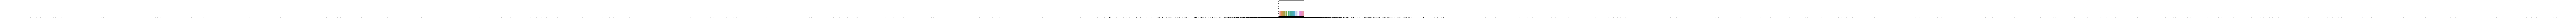

In [ ]:
sns.countplot(x = url_attr, data = df, order = df['url'].value_counts().index)

### What does this show?
* There are a lot more `benign` URL's compared to the other target classes
* The dataset is really imbalanced. It might be an idea after the analysis to sub-sample the benign URL's so we have a 100K examples and then upsample the `malware` class to 100K too.

# Feature Engineering

There are several different tactics we can take here. Due to URL's essentially just being text, it opens us up to tonnes of options using techniques used for Natural Language Procesing (NLP). We also have several features associated with URL specifically such as what is the top level domain, whats the prefix or does it have a sub domain.

Several other Kaggler's have also had a crack at this dataset before me, so I will shamelessly copy their great work (Check out the notebooks here -  [@sid321axn](https://www.kaggle.com/sid321axn/malicious-url-detection-using-ml-feat-engg) and [capsalisp](https://www.kaggle.com/capsalisp/decision-tree-and-xgboost))

## Is the URL actually an IP Address? If so, of which type?

In [ ]:
# Taken from & amended from @sid321xan notebook
def is_url_ip_address(url: str) -> bool:
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4 with port
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'
        '([0-9]+(?:\.[0-9]+){3}:[0-9]+)|'
        '((?:(?:\d|[01]?\d\d|2[0-4]\d|25[0-5])\.){3}(?:25[0-5]|2[0-4]\d|[01]?\d\d|\d)(?:\/\d{1,2})?)', url)  # Ipv6
    if match:
        return 1
    else:
        return 0

df['is_ip'] = df[url_attr].apply(lambda i: is_url_ip_address(i))

In [ ]:
df['is_ip'].value_counts()

0    12446
1       43
Name: is_ip, dtype: int64

## Top Level Domain Features

Let's take a sample URL and see what features we can get out of it using the `tld` python library

In [ ]:
sample = df[url_attr].iloc[4]
sample

'http://sfr-suivi-client.com/'

In [ ]:
res = get_tld(sample, as_object=True)
res

com

In [ ]:
res.subdomain

''

In [ ]:
res.domain

'sfr-suivi-client'

In [ ]:
res.tld

'com'

In [ ]:
res.fld

'sfr-suivi-client.com'

The `tld` library looks like something which could be useful for parsing URL's and extracting the useful components. Let's create some helper functions to aid with the processing

### URL Processing Helpers

In [ ]:
def process_tld(url: str, fix_protos: bool = False) -> Tuple[str, str, str, str]:
    """
    Takes a URL string and uses the tld library to extract subdomain, domain, top
    level domain and full length domain
    """
    res = get_tld(url, as_object = True, fail_silently=False, fix_protocol=fix_protos)

    subdomain = res.subdomain
    domain = res.domain
    tld = res.tld
    fld = res.fld

    return subdomain, domain, tld, fld

def process_url_with_tld(row: pd.Series) -> Tuple[str, str, str, str]:
    """
    Takes in a dataframe row, checks to see if rows `is_ip` column is
    False. If it is false, continues to process the URL and extract the
    features, otherwise sets four features to None before returning.

    This processing is wrapped in a try/except block to enable debugging
    and it prints out the inputs that caused a failure as well as a
    failure counter.
    """
    try:
        if row['is_ip'] == 0:
            if str(row[url_attr]).startswith('http:'):
                return process_tld(row[url_attr])
            else:
                return process_tld(row[url_attr], fix_protos=True)
        else:
            subdomain = None
            domain = None
            tld = None
            fld = None
            return subdomain, domain, tld, fld
    except:
        idx = row.name
        url = row[url_attr]
        type = row[category_attr]
        print(f'Failed - {idx}: {url} is a {type} example')
        return None, None, None, None

In [ ]:
df[['subdomain', 'domain', 'tld', 'fld']] = df.apply(lambda x: process_url_with_tld(x), axis=1, result_type="expand")

Failed - 447: Https://renta-futura.cl/lmcu/Login/ is a Other example


Oh no. It looks like the processing function above seems to be failing on certain types of URL's. From looking at the ones it failed on. The URL's looks like they are encoded in some way and I am unsure what sort of encoding it is.  Let's see how many failed.
### Checking Processed Values

In [ ]:
df[['subdomain', 'domain', 'tld', 'fld']].value_counts()

subdomain   domain                    tld      fld                             
docs        google                    com      google.com                          237
sites       google                    com      google.com                          236
storageapi  fleek                     co       fleek.co                            139
            is                        gd       is.gd                               104
            tribelio                  page     tribelio.page                       101
                                                                                  ... 
            seguridad--galiciaem      repl.co  seguridad--galiciaem.repl.co          1
            seguridad--onlinebank255  repl.co  seguridad--onlinebank255.repl.co      1
            seguridad781              repl.co  seguridad781.repl.co                  1
            segurosdelestadoam        com      segurosdelestadoam.com                1
ztowf4      webwave                   dev      web

### Checking how many slipped through the cracks?

In [ ]:
df[['subdomain', 'domain', 'tld', 'fld']].isna().sum(), df['is_ip'].value_counts()

(subdomain    44
 domain       44
 tld          44
 fld          44
 dtype: int64, 0    12446
 1       43
 Name: is_ip, dtype: int64)

In [ ]:
df[['subdomain', 'domain', 'tld', 'fld']].isna().sum()[0] -  df['is_ip'].value_counts()[1]

1

From running that code snippet above which is looking for all rows where the new engineered featuresa are empty and the row is an IP, it looks like 90 managed to slip through the cracks. This is not so bad given the total number of URL's above.

## Check what the data looks like now

In [ ]:
df.head()

,phish_id,url,phish_detail_url,submission_time,verified,verification_time,online,target,is_ip,subdomain,domain,tld,fld
0,7998179,https://xn--impay-sfr-f4a.com/,http://www.phishtank.com/phish_detail.php?phis...,2023-01-05T09:24:25+00:00,yes,2023-01-05T09:32:52+00:00,yes,Other,0,,xn--impay-sfr-f4a,com,xn--impay-sfr-f4a.com
1,7998177,http://www.sfr-suivi-client.com/,http://www.phishtank.com/phish_detail.php?phis...,2023-01-05T09:24:09+00:00,yes,2023-01-05T09:32:52+00:00,yes,Other,0,www,sfr-suivi-client,com,sfr-suivi-client.com
2,7998178,https://www.sfr-suivi-client.com/login.php,http://www.phishtank.com/phish_detail.php?phis...,2023-01-05T09:24:09+00:00,yes,2023-01-05T09:32:52+00:00,yes,Other,0,www,sfr-suivi-client,com,sfr-suivi-client.com
3,7998176,https://sfr-suivi-client.com/login.php,http://www.phishtank.com/phish_detail.php?phis...,2023-01-05T09:23:41+00:00,yes,2023-01-05T09:32:52+00:00,yes,Other,0,,sfr-suivi-client,com,sfr-suivi-client.com
4,7998175,http://sfr-suivi-client.com/,http://www.phishtank.com/phish_detail.php?phis...,2023-01-05T09:23:40+00:00,yes,2023-01-05T09:32:52+00:00,yes,Other,0,,sfr-suivi-client,com,sfr-suivi-client.com


# Adding some extra features

Now that we have extracted the above features, let's extract some more! Below are some helper functions taken from other notebooks to get us going

In [ ]:
def get_url_path(url: str) -> Union[str, None]:
    """
    Get's the path from a URL

    For example:

    If the URL was "www.google.co.uk/my/great/path"

    The path returned would be "my/great/path"
    """
    try:
        res = get_tld(url, as_object = True, fail_silently=False, fix_protocol=True)
        if res.parsed_url.query:
            joined = res.parsed_url.path + res.parsed_url.query
            return joined
        else:
            return res.parsed_url.path
    except:
        return None

def alpha_count(url: str) -> int:
    """
    Counts the number of alpha characters in a URL
    """
    alpha = 0
    for i in url:
        if i.isalpha():
            alpha += 1
    return alpha

def digit_count(url: str) -> int:
    """
    Counts the number of digit characters in a URL
    """
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

def count_dir_in_url_path(url_path: Union[str, None]) -> int:
    """
    Counts number of / in url path to count number of
    sub directories
    """
    if url_path:
        n_dirs = url_path.count('/')
        return n_dirs
    else:
        return 0

def get_first_dir_len(url_path: Union[str, None]) -> int:
    """
    Counts the length of the first directory within
    the URL provided
    """
    if url_path:
        if len(url_path.split('/')) > 1:
            first_dir_len = len(url_path.split('/')[1])
            return first_dir_len
    else:
        return 0

def contains_shortening_service(url: str) -> int:
    """
    Checks to see whether URL contains a shortening service
    """
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

### Features that are going to be added
**General Features**

1. `url_path` - The URL pathis the section after any of the domain name and area extension. Typically these are fairly short and human readable. A long `url_path` could mean that it's been automatically/randomly generated.
2. `contains shortener` - This feature is generated by checking whether the URl includes any of the common URL shorteners.

**URL Component Lengths**

3. `url_len` - The length of the whole URL
4. `subdomian_len` - The legnth of the URL's subdomain if present, 0 otherwise
5. `tld_len` - The length of the top-level domain
6. `fld_len`- The length of the full-legnth domain
7. `url_path_len` - The length of the path after the full-length domain.

**Count Features**

8. `url_alphas` - A count of the alpha characters within the URL.
9. `url_digits` - A count of the digit/numbers within the URL.
10. `url_puncs` - A count of the punctuation within the whole URL.
11. `count.` - A count of the number of fullstops within the URL.
12. `count@` - A count of the number of full stops within the URL.
13. `count-` - A count of the number of dahses within the URL.
14. `count%` - A count of the number of % within the URL.
15. `count?` - A count of the number of ? within the URL.
16. `count=` - A count of the number of = within the URL.
17. `count_dirs` - A count of the number of directories within `url_path`.
18. `first_dir_len` - A count of the legnth of the first directory within `url_path`.

**Binary Label**

19. `binary_label` - A binary label where 0 denotes benign and 1 denotes malicious (i.e a combination of all other classes)

**Binned Features**

20. `url_len_q` - This feature uses the `url_len` feature above and puts each sample/row into 4 groups based on the quantile they fit into. For example, if a value was in the 85th percentile, it would be put into the 'Very Long' group.
21. `fld_len_q` - This is feature is the same but instead of the whole URL, just does it for 'fld'

**Ratio Features**

22. `pc_alphas` - The percentage of alphas/letters in the URL
23. `pc_digits` - The percentage of digits/numbers in the URL
24. `pc_puncs` - The perctange of puncutation in the URL

### Reasoning / Commentary on Feature Choices

The vast majority of the features above have been inspired by or directly copied from the great work by the other Kaggler's who have done some great work on this dataset already - This includes all of the count features and most of the URL component length features.

The bit I have added is the binned and ratio features. The thinking behind both of these is that these features may provide a good signal to the model of malicious URL's. For example, if a URL has `url_len_q` value of `Very Long` and also has a `pc_puncs` values of 95%, that suggests something is a bit wierd here right? I also plan to do some feature importance analysis below when I have trained the models to see if these actually contribute to good predictions and if they do, it may warrant some further feature engineering (such as computing ratio features for all of the individual URL components not just the URL as a whole)



In [ ]:
# General Features
df['url_path'] = df[url_attr].apply(lambda x: get_url_path(x))
df['contains_shortener'] = df[url_attr].apply(lambda x: contains_shortening_service(x))

# URL component length
df['url_len'] = df[url_attr].apply(lambda x: len(str(x)))
df['subdomain_len'] = df['subdomain'].apply(lambda x: len(str(x)))
df['tld_len'] = df['tld'].apply(lambda x: len(str(x)))
df['fld_len'] = df['fld'].apply(lambda x: len(str(x)))
df['url_path_len'] = df['url_path'].apply(lambda x: len(str(x)))

# Simple count features
df['url_alphas']= df[url_attr].apply(lambda i: alpha_count(i))
df['url_digits']= df[url_attr].apply(lambda i: digit_count(i))
df['url_puncs'] = (df['url_len'] - (df['url_alphas'] + df['url_digits']))
df['count.'] = df[url_attr].apply(lambda x: x.count('.'))
df['count@'] = df[url_attr].apply(lambda x: x.count('@'))
df['count-'] = df[url_attr].apply(lambda x: x.count('-'))
df['count%'] = df[url_attr].apply(lambda x: x.count('%'))
df['count?'] = df[url_attr].apply(lambda x: x.count('?'))
df['count='] = df[url_attr].apply(lambda x: x.count('='))
df['count_dirs'] = df['url_path'].apply(lambda x: count_dir_in_url_path(x))
df['first_dir_len'] = df['url_path'].apply(lambda x: get_first_dir_len(x))

# Binary Label
df['binary_label'] = df[category_attr].apply(lambda x: 0 if x == 'benign' else 1)

# Binned Features
groups = ['Short', 'Medium', 'Long', 'Very Long']
# URL Lengths in 4 bins
df['url_len_q'] = pd.qcut(df['url_len'], q=4, labels=groups)
# FLD Lengths in 4 bins
df['fld_len_q'] = pd.qcut(df['fld_len'], q=4, labels=groups)

# Percentage Features
df['pc_alphas'] = df['url_alphas'] / df['url_len']
df['pc_digits'] = df['url_digits'] / df['url_len']
df['pc_puncs'] = df['url_puncs'] / df['url_len']

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
df[["url_len_q","fld_len_q"]] = enc.fit_transform(df[["url_len_q","fld_len_q"]])

In [ ]:
df.head()

,phish_id,url,phish_detail_url,submission_time,verified,verification_time,online,target,is_ip,subdomain,...,count?,count=,count_dirs,first_dir_len,binary_label,url_len_q,fld_len_q,pc_alphas,pc_digits,pc_puncs
0,7998179,https://xn--impay-sfr-f4a.com/,http://www.phishtank.com/phish_detail.php?phis...,2023-01-05T09:24:25+00:00,yes,2023-01-05T09:32:52+00:00,yes,Other,0,,...,0,0,1,0,1,2.0,3.0,0.666667,0.033333,0.300000
1,7998177,http://www.sfr-suivi-client.com/,http://www.phishtank.com/phish_detail.php?phis...,2023-01-05T09:24:09+00:00,yes,2023-01-05T09:32:52+00:00,yes,Other,0,www,...,0,0,1,0,1,1.0,0.0,0.750000,0.000000,0.250000
2,7998178,https://www.sfr-suivi-client.com/login.php,http://www.phishtank.com/phish_detail.php?phis...,2023-01-05T09:24:09+00:00,yes,2023-01-05T09:32:52+00:00,yes,Other,0,www,...,0,0,1,9,1,0.0,0.0,0.785714,0.000000,0.214286
3,7998176,https://sfr-suivi-client.com/login.php,http://www.phishtank.com/phish_detail.php?phis...,2023-01-05T09:23:41+00:00,yes,2023-01-05T09:32:52+00:00,yes,Other,0,,...,0,0,1,9,1,0.0,0.0,0.789474,0.000000,0.210526
4,7998175,http://sfr-suivi-client.com/,http://www.phishtank.com/phish_detail.php?phis...,2023-01-05T09:23:40+00:00,yes,2023-01-05T09:32:52+00:00,yes,Other,0,,...,0,0,1,0,1,2.0,0.0,0.750000,0.000000,0.250000


# Analysing and Visualising New Features

In [ ]:
df.describe()

,phish_id,is_ip,contains_shortener,url_len,subdomain_len,tld_len,fld_len,url_path_len,url_alphas,url_digits,...,count?,count=,count_dirs,first_dir_len,binary_label,url_len_q,fld_len_q,pc_alphas,pc_digits,pc_puncs
count,1.248900e+04,12489.000000,12489.000000,12489.000000,12489.000000,12489.000000,12489.000000,12489.000000,12489.000000,12489.000000,...,12489.000000,12489.000000,12489.000000,12489.000000,12489.0,12489.000000,12489.000000,12489.000000,12489.000000,12489.000000
mean,7.805473e+06,0.003443,0.068861,48.581071,6.666907,4.764593,16.482825,15.925615,35.607975,4.951397,...,0.099848,0.153015,1.468492,5.706702,1.0,1.531908,1.587237,0.730679,0.085437,0.183884
std,3.822097e+05,0.058579,0.253227,63.468713,9.597240,3.822452,8.707415,36.008598,52.441187,11.243482,...,0.312623,0.711093,1.247992,16.252528,0.0,1.087593,1.058325,0.097767,0.096456,0.041167
min,5.491590e+05,0.000000,0.000000,15.000000,0.000000,2.000000,4.000000,0.000000,4.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.173913,0.000000,0.005867
25%,7.724777e+06,0.000000,0.000000,31.000000,0.000000,3.000000,11.000000,1.000000,22.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.0,1.000000,1.000000,0.638889,0.000000,0.158537
50%,7.970613e+06,0.000000,0.000000,36.000000,4.000000,3.000000,14.000000,1.000000,26.000000,2.000000,...,0.000000,0.000000,1.000000,0.000000,1.0,2.000000,2.000000,0.756757,0.057143,0.188679
75%,7.993022e+06,0.000000,0.000000,50.000000,11.000000,5.000000,20.000000,16.000000,38.000000,6.000000,...,0.000000,0.000000,1.000000,6.000000,1.0,2.000000,2.000000,0.807692,0.166667,0.205882
max,7.998179e+06,1.000000,1.000000,5795.000000,76.000000,37.000000,80.000000,784.000000,4998.000000,763.000000,...,4.000000,15.000000,13.000000,592.000000,1.0,3.000000,3.000000,0.943333,0.621951,0.380952


There are several interesting things that can be taken from looking at this output above. The `url_len` range is MAAAAHOSIVE. The average being 60 but the max is 2175. This screams like there are some outliers here and it might be worth trying to realign those. Also, from looking at `subdomain_len` and `url_path_len`, the crazy length is coming from one or several outliers within the `url_path` part of the URL's. There also looks like there are several punctuations such as `%` which represent large proportions of the URL's. This may be worth investigating further later perhaps.

## Visualising the different URL Component Lengths

Text(0.5, 1.0, 'Full Length Domain Length')

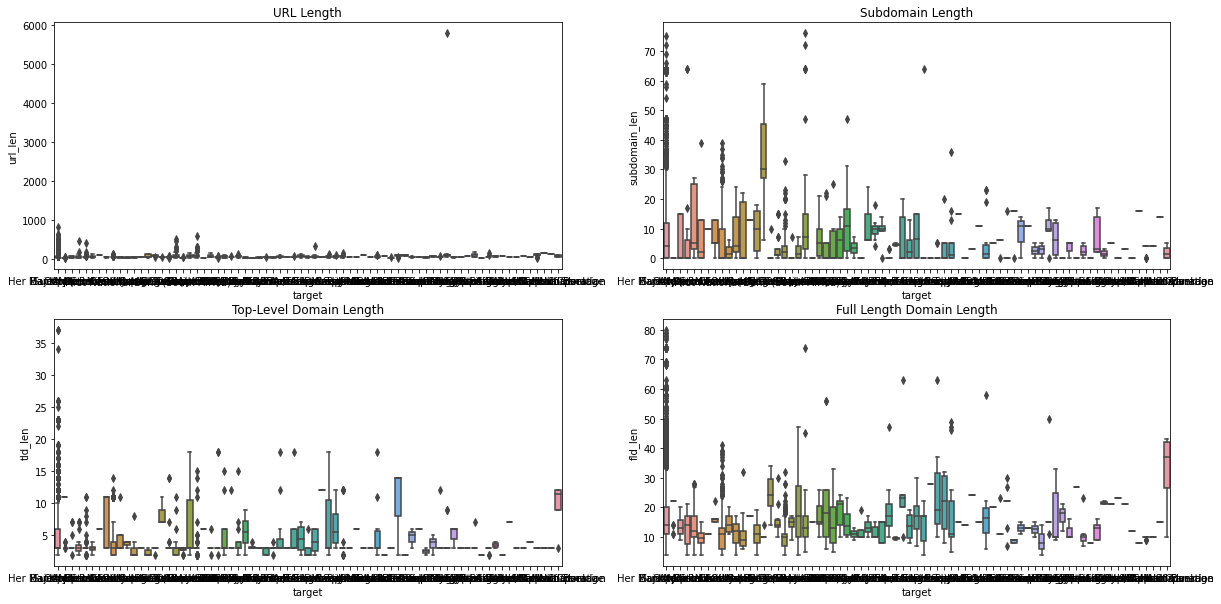

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(20, 10), sharey=False)
sns.boxplot(ax=axes[0, 0], x=category_attr, y='url_len', data=df)
axes[0, 0].set_title('URL Length')
sns.boxplot(ax=axes[0, 1], x=category_attr, y='subdomain_len', data=df)
axes[0, 1].set_title('Subdomain Length')
sns.boxplot(ax=axes[1, 0], x=category_attr, y='tld_len', data=df)
axes[1, 0].set_title('Top-Level Domain Length')
sns.boxplot(ax=axes[1, 1], x=category_attr, y='fld_len', data=df)
axes[1, 1].set_title('Full Length Domain Length')

## Visualising the ratio of different character types to URL Length

Text(0.5, 1.0, 'Ratio of Digits to URL')

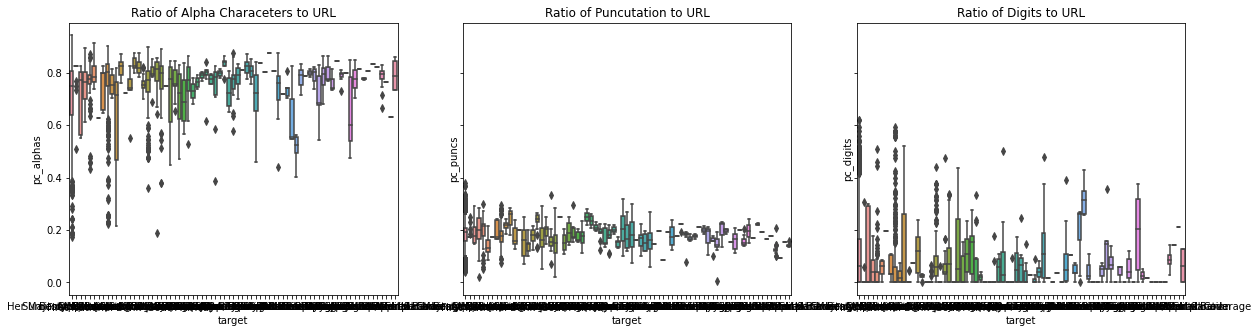

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
sns.boxplot(ax=axes[0], x=category_attr, y='pc_alphas', data=df)
axes[0].set_title('Ratio of Alpha Characeters to URL')
sns.boxplot(ax=axes[1], x=category_attr, y='pc_puncs', data=df)
axes[1].set_title('Ratio of Puncutation to URL')
sns.boxplot(ax=axes[2], x=category_attr, y='pc_digits', data=df)
axes[2].set_title('Ratio of Digits to URL')

## Visualising the ratio of different character types to URL Length with Quartile Hue's

Text(0.5, 1.0, 'Ratio of Digits to URL')

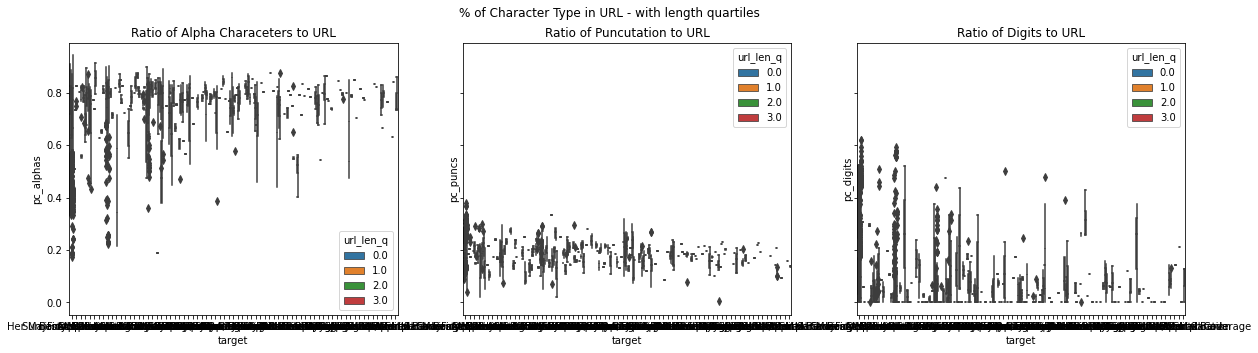

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
fig.suptitle('% of Character Type in URL - with length quartiles')
sns.boxplot(ax=axes[0], x=category_attr, y='pc_alphas', hue='url_len_q', data=df)
axes[0].set_title('Ratio of Alpha Characeters to URL')
sns.boxplot(ax=axes[1], x=category_attr, y='pc_puncs', hue='url_len_q', data=df)
axes[1].set_title('Ratio of Puncutation to URL')
sns.boxplot(ax=axes[2], x=category_attr, y='pc_digits', hue='url_len_q', data=df)
axes[2].set_title('Ratio of Digits to URL')

## Visualising the ratio of different character types to URL Length with Quartile Hue's - Kernel Density Estimatation

*Note: I have no idea how to actually interpret these. From reading wikipedia, it looks like they are eseentially smoothed histograms. Because most of these plots have such long tails, this visualisation can probs' be binned*

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


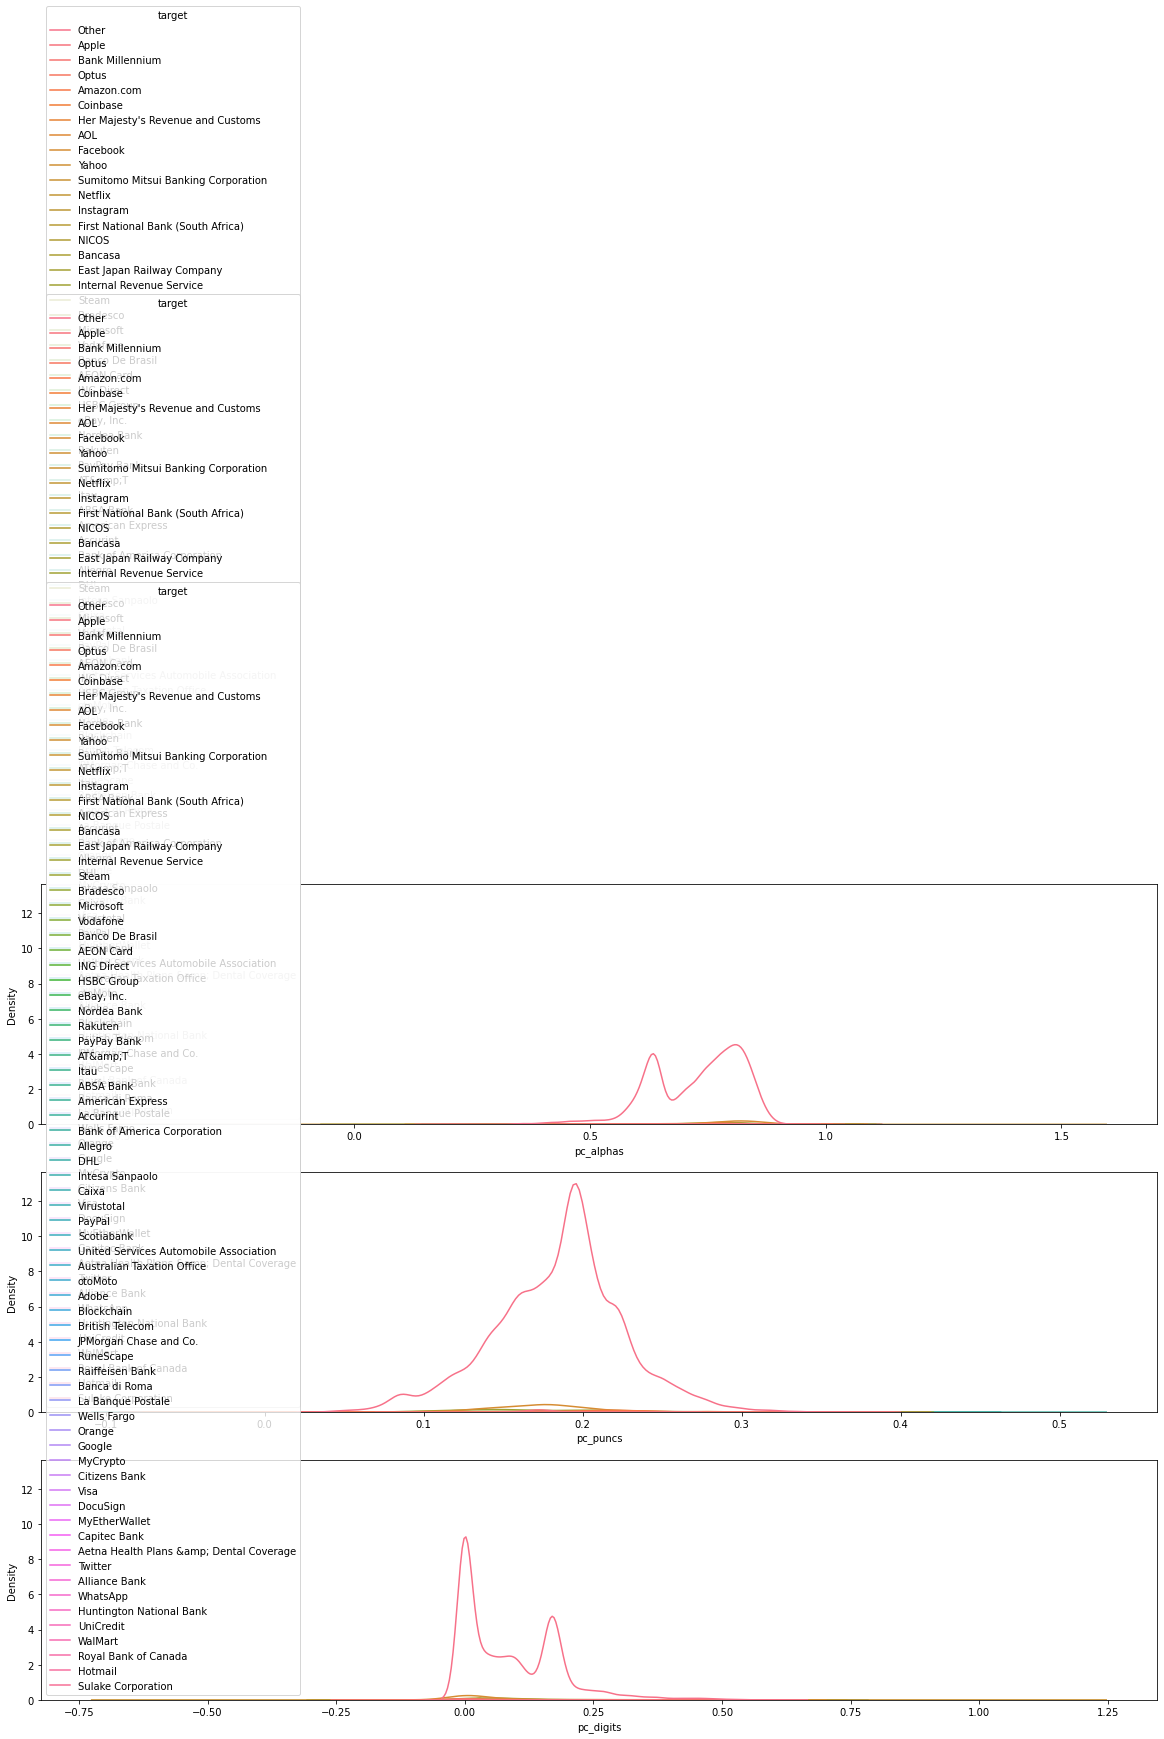

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(20, 15), sharey=True)
sns.kdeplot(ax=axes[0], data=df, x="pc_alphas", hue=category_attr)
sns.kdeplot(ax=axes[1], data=df, x="pc_puncs", hue=category_attr)
sns.kdeplot(ax=axes[2], data=df, x="pc_digits", hue=category_attr)

# Model Training - Binary Label

In [ ]:
X = df[['is_ip', 'url_len', 'subdomain_len', 'tld_len', 'fld_len', 'url_path_len',
       'url_alphas', 'url_digits', 'url_puncs', 'count.', 'count@', 'count-',
       'count%', 'count?', 'count=',
       'pc_alphas', 'pc_digits', 'pc_puncs', 'count_dirs',
       'contains_shortener', 'first_dir_len',
       'url_len_q', 'fld_len_q']]

y = df['binary_label']

## Pre-Model Train Feature Checks

In [ ]:
X.isna().sum()

is_ip                 0
url_len               0
subdomain_len         0
tld_len               0
fld_len               0
url_path_len          0
url_alphas            0
url_digits            0
url_puncs             0
count.                0
count@                0
count-                0
count%                0
count?                0
count=                0
pc_alphas             0
pc_digits             0
pc_puncs              0
count_dirs            0
contains_shortener    0
first_dir_len         0
url_len_q             0
fld_len_q             0
dtype: int64

Looks like we have a minor problem here - The `first_dir_len` feature seems to have a number of `NaNs` - Lets see whats up!

In [ ]:
X[X.isnull().any(axis=1)]

,is_ip,url_len,subdomain_len,tld_len,fld_len,url_path_len,url_alphas,url_digits,url_puncs,count.,...,count?,count=,pc_alphas,pc_digits,pc_puncs,count_dirs,contains_shortener,first_dir_len,url_len_q,fld_len_q


Looking at the above dataframe is not much help to work out what is actually going on here. All of the URL's have a value for `url_path_len` which should mean that they should have values. Let's run a similar query of the original dataframe prior to dropping the non-model training features.

In [ ]:
df[df['first_dir_len'].isnull()]

,phish_id,url,phish_detail_url,submission_time,verified,verification_time,online,target,is_ip,subdomain,...,count?,count=,count_dirs,first_dir_len,binary_label,url_len_q,fld_len_q,pc_alphas,pc_digits,pc_puncs


It looks like all of these are failing becuase the `url_path` value is not necessaryily a path and includes a `/` which is the splitting character used within the function. Rather than refactoring the code above and due to the number of errors being so low, I think it's OK to impute the values are set them all to `0`.

In [ ]:
X['first_dir_len'].value_counts()

0      7589
4       655
5       487
8       352
6       313
       ... 
243       1
90        1
223       1
82        1
115       1
Name: first_dir_len, Length: 117, dtype: int64

In [ ]:
X = X.fillna(0)

In [ ]:
X.isna().sum()

is_ip                 0
url_len               0
subdomain_len         0
tld_len               0
fld_len               0
url_path_len          0
url_alphas            0
url_digits            0
url_puncs             0
count.                0
count@                0
count-                0
count%                0
count?                0
count=                0
pc_alphas             0
pc_digits             0
pc_puncs              0
count_dirs            0
contains_shortener    0
first_dir_len         0
url_len_q             0
fld_len_q             0
dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=2)

## Train all the trees!

In [ ]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(objective='binary',boosting_type= 'gbdt',n_jobs = 5,
          silent = True, random_state=5)
LGB_C = lgb.fit(X_train, y_train)


y_pred = LGB_C.predict(X_test)
print(classification_report(y_test, y_pred))

score = accuracy_score(y_test, y_pred)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      2498

    accuracy                           1.00      2498
   macro avg       1.00      1.00      1.00      2498
weighted avg       1.00      1.00      1.00      2498

accuracy:   1.000


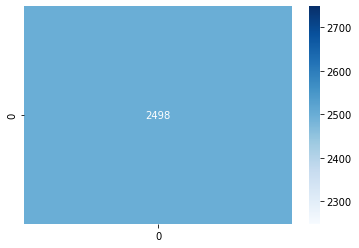

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', cmap='Blues')

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier(n_estimators= 100)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))


score = accuracy_score(y_test, y_pred)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      2498

    accuracy                           1.00      2498
   macro avg       1.00      1.00      1.00      2498
weighted avg       1.00      1.00      1.00      2498

accuracy:   1.000


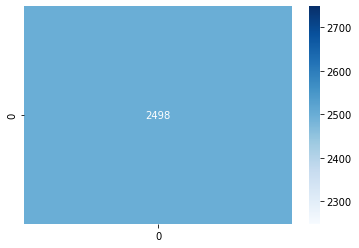

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', cmap='Blues')

In [ ]:
# from sklearn.ensemble import GradientBoostingClassifier
# gbdt = GradientBoostingClassifier(n_estimators=100,max_features='sqrt')
# gbdt.fit(X_train,y_train)
# y_pred = gbdt.predict(X_test)
# print(classification_report(y_test,y_pred))

# score = accuracy_score(y_test, y_pred)
# print("accuracy:   %0.3f" % score)

In [ ]:
# sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', cmap='Blues')

It looks like we are getting somewhere and are getting similar results to some of the other notebooks - The new features don't seem to be making a huge difference on the `binary_label` problem. Let's use the same data to train the a multi-class version of all of the models above.

# Model Training - Multi-Class

## Get multi-class labels

In [ ]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df["multi_label"] = lb_make.fit_transform(df[category_attr])
df["multi_label"].value_counts()

50    11244
28      399
37      214
9        99
42       65
      ...  
12        1
63        1
66        1
32        1
57        1
Name: multi_label, Length: 73, dtype: int64

In [ ]:
y = df['multi_label']

In [ ]:
def create_multi_class_conf_matrix_plot(y_test, y_pred):

    tick_labels = ['benign', 'defacement','phishing','malware']
    fig, axes = plt.subplots(1, figsize=(10, 10), sharey=True)
    sns.heatmap(confusion_matrix(y_test, y_pred), ax=axes, annot=True, fmt='g', cmap='Blues')
    axes.set_xticklabels(tick_labels)
    axes.set_yticklabels(tick_labels)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=5)

In [ ]:
lgb = LGBMClassifier(objective='binary',boosting_type= 'gbdt',n_jobs = 5,
          silent = True, random_state=5)
LGB_C = lgb.fit(X_train, y_train)


y_pred = LGB_C.predict(X_test)
print(classification_report(y_test, y_pred))

score = accuracy_score(y_test, y_pred)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         2
           9       0.00      0.00      0.00        13
          11       0.00      0.00      0.00        12
          15       0.00      0.00      0.00         3
          16       0.00      0.00      0.00         3
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         4
          20       0.00      0.00      0.00         1
          21       0.00      0.00      0.00         3
          23       0.00      0.00      0.00         1
          25       0.00      0.00      0.00         1
          26       0.00    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Text(0, 0.5, 'benign'),
 Text(0, 1.5, 'defacement'),
 Text(0, 2.5, 'phishing'),
 Text(0, 3.5, 'malware')]

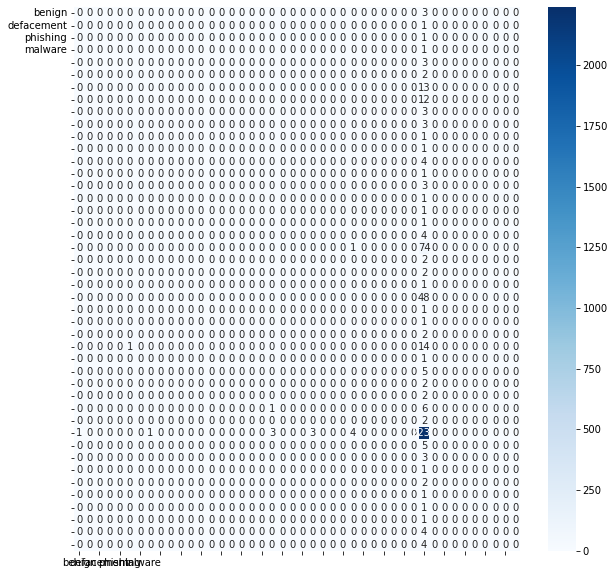

In [ ]:
tick_labels = ['benign', 'defacement','phishing','malware']
fig, axes = plt.subplots(1, figsize=(10, 10), sharey=True)
sns.heatmap(confusion_matrix(y_test, y_pred), ax=axes, annot=True, fmt='g', cmap='Blues')
axes.set_xticklabels(tick_labels)
axes.set_yticklabels(tick_labels)

In [ ]:
lgb_features = lgb.feature_importances_.tolist()

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier(n_estimators= 100)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))


score = accuracy_score(y_test, y_pred)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         2
           9       0.62      0.38      0.48        13
          11       0.86      1.00      0.92        12
          15       0.00      0.00      0.00         3
          16       0.00      0.00      0.00         3
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         4
          20       0.00      0.00      0.00         1
          21       0.00      0.00      0.00         3
          23       0.00      0.00      0.00         1
          25       0.00    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1

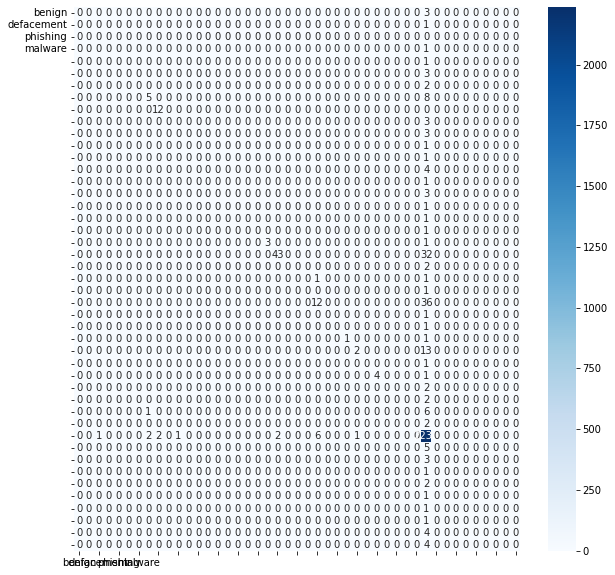

In [ ]:
create_multi_class_conf_matrix_plot(y_test, y_pred)

In [ ]:
xgb_features = model.feature_importances_.tolist()

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbdt = GradientBoostingClassifier(n_estimators=100,max_features='sqrt')
gbdt.fit(X_train,y_train)
y_pred = gbdt.predict(X_test)
print(classification_report(y_test,y_pred))

score = accuracy_score(y_test, y_pred)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00        13
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00        12
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         3
          16       0.00      0.00      0.00         3
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         4
          20       0.00    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1

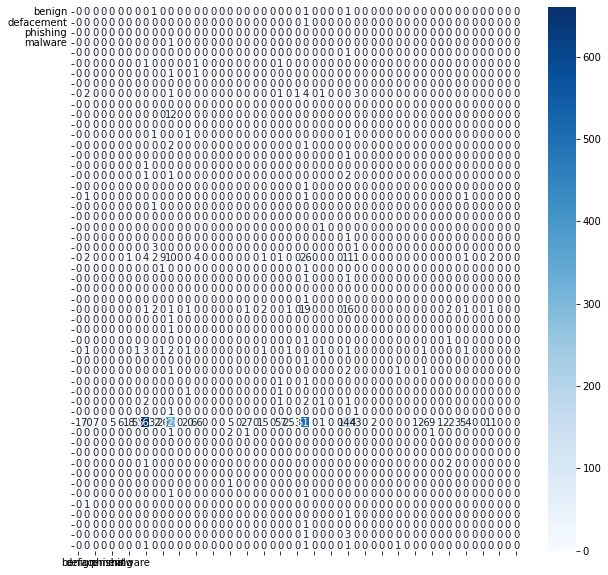

In [ ]:
create_multi_class_conf_matrix_plot(y_test, y_pred)

In [ ]:
gbdt_features = gbdt.feature_importances_.tolist()

## Feature Importance Analysis

In [ ]:
cols = X.columns
feature_importances = pd.DataFrame({'features': cols,

    'gbt': gbdt_features,
    'xgb': xgb_features,
    'lgbm': lgb_features
    })

In [ ]:
feature_importances['mean_importance'] = feature_importances.mean(axis=1)

<ipython-input-131-2bdc5ed6a74c>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  feature_importances['mean_importance'] = feature_importances.mean(axis=1)


In [ ]:
feature_importances = feature_importances.sort_values(by='mean_importance', ascending=False)

In [ ]:
feature_importances

,features,gbt,xgb,lgbm,mean_importance
4,fld_len,0.044315,0.051210,7706,2568.698508
15,pc_alphas,0.168329,0.029451,6170,2056.732593
17,pc_puncs,0.059475,0.031821,5916,1972.030432
1,url_len,0.090923,0.039355,5029,1676.376760
5,url_path_len,0.058123,0.075208,3982,1327.377777
2,subdomain_len,0.064100,0.043996,3866,1288.702699
20,first_dir_len,0.041253,0.031950,3800,1266.691068
3,tld_len,0.025006,0.074547,3618,1206.033184
6,url_alphas,0.078200,0.039390,3592,1197.372530
16,pc_digits,0.104409,0.031936,2182,727.378782


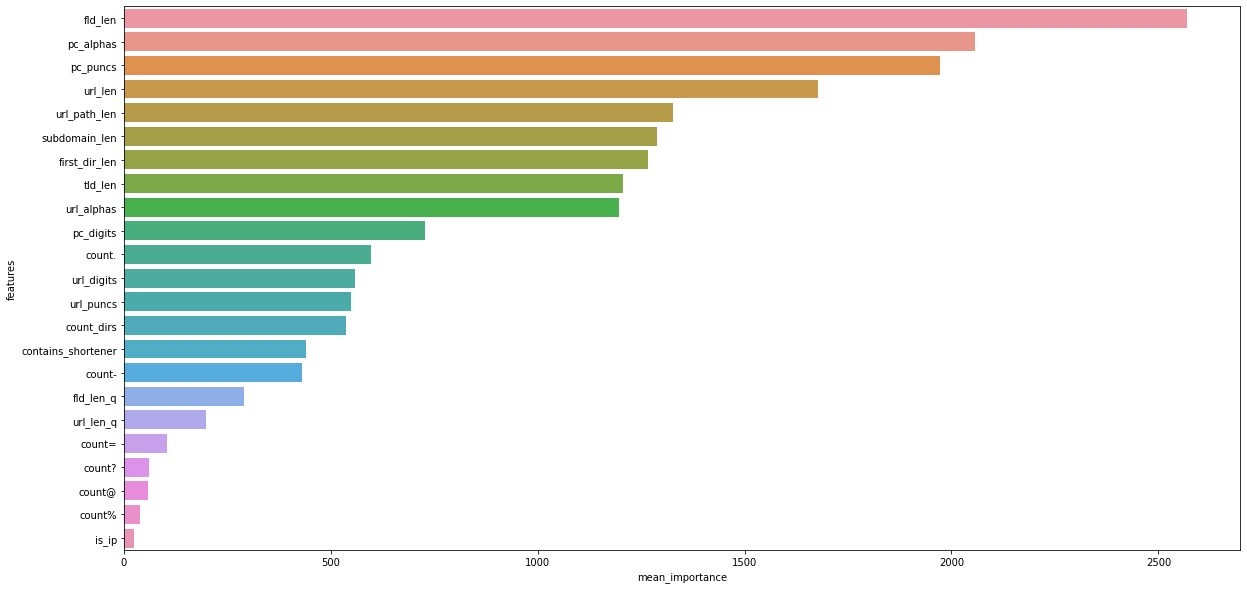

In [ ]:
fig, axes = plt.subplots(1, figsize=(20, 10))
sns.barplot(data=feature_importances, x="mean_importance", y='features', ax=axes)

The plot above I feel only tells on story - Becuase the `mean` measure of centrality has been used, it's heavily skewed by the feature importance values of the LGBM model. Let's see what the feature importances look like for individual models.

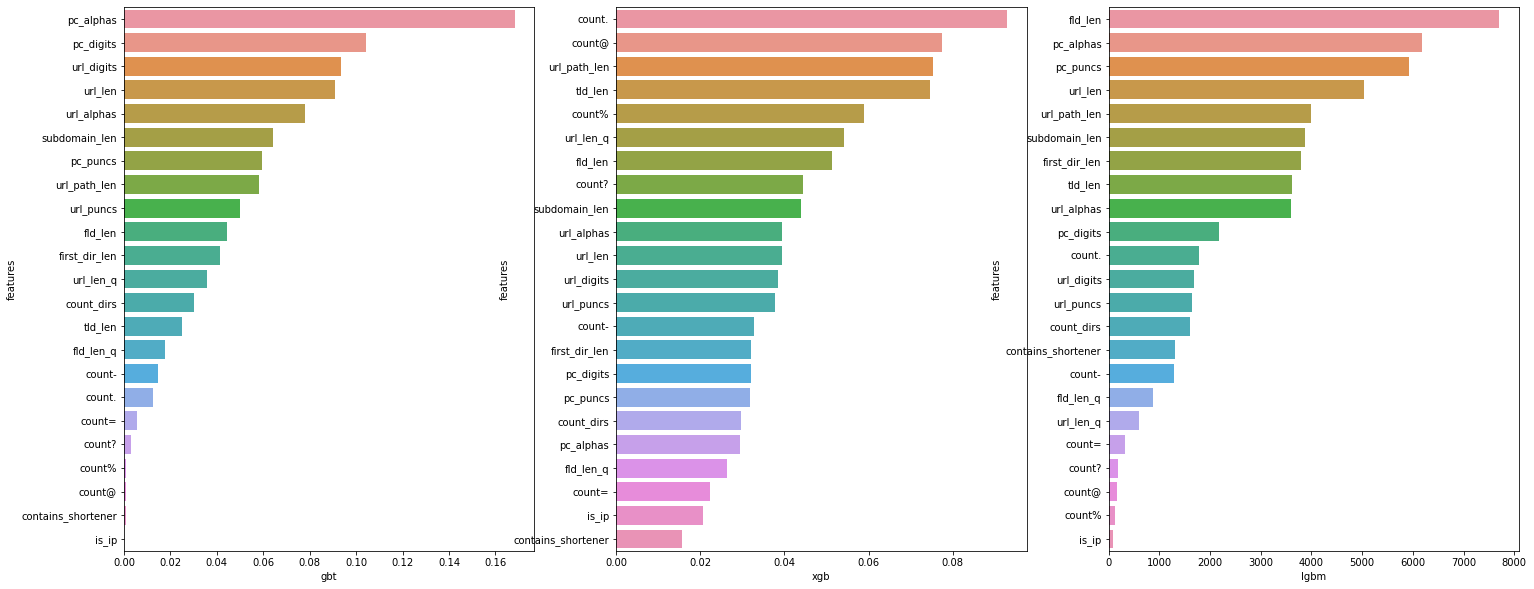

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(25, 10))
feature_importances = feature_importances.sort_values(by='gbt', ascending=False)
sns.barplot(data=feature_importances, x="gbt", y='features', ax=axes[0])
feature_importances = feature_importances.sort_values(by='xgb', ascending=False)
sns.barplot(data=feature_importances, x="xgb", y='features', ax=axes[1])
feature_importances = feature_importances.sort_values(by='lgbm', ascending=False)
sns.barplot(data=feature_importances, x="lgbm", y='features', ax=axes[2])

Still looks like a mixed bag and its a bit difficult to see the wood from the trees. Let's create some feature rankings based on each of the models feature importances and then mean those.

In [ ]:
feature_importances['gbt_rank'] = feature_importances['gbt'].rank()
feature_importances['xgb_rank'] = feature_importances['xgb'].rank()
feature_importances['lgbm_rank'] = feature_importances['lgbm'].rank()

In [ ]:
feature_importances['avg_rank'] = feature_importances[['gbt_rank', 'xgb_rank', 'lgbm_rank']].mean(axis=1)

Text(0, 0.5, 'Feature')

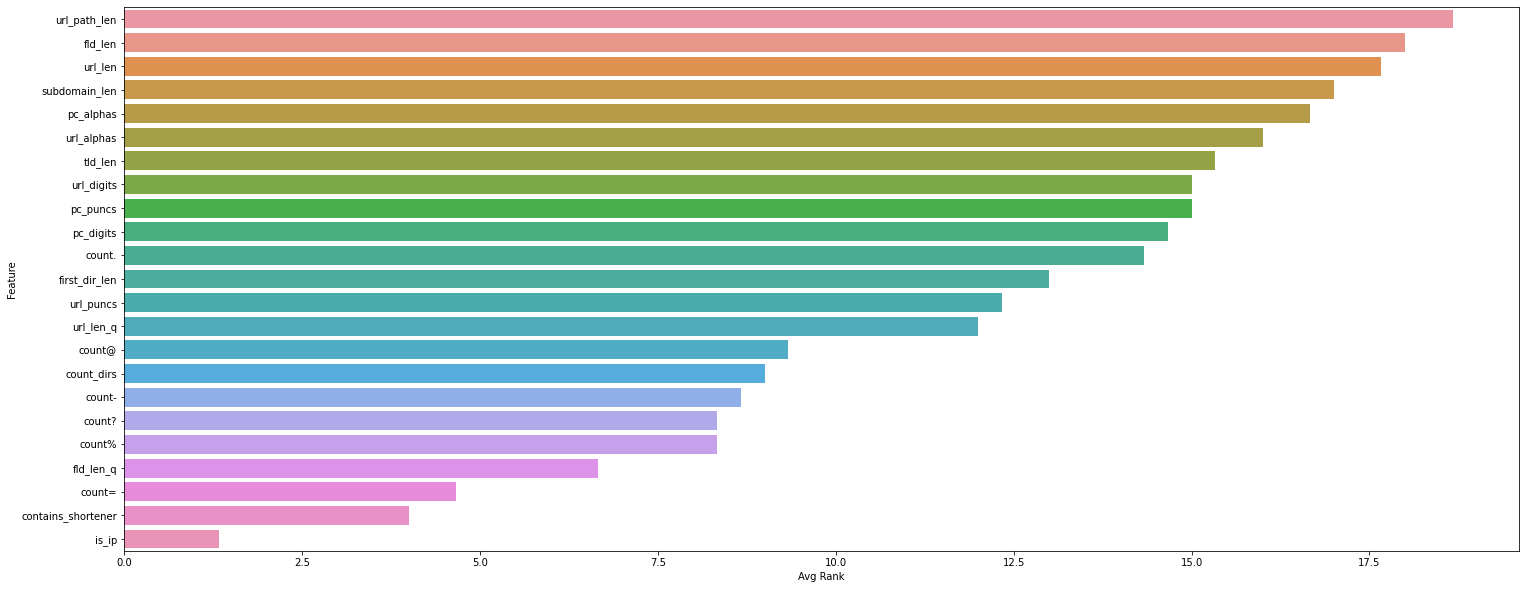

In [ ]:
feature_importances = feature_importances.sort_values(by='avg_rank', ascending=False)
fig, axes = plt.subplots(1, figsize=(25, 10))
sns.barplot(data=feature_importances, x="avg_rank", y='features')
axes.set_xlabel('Avg Rank')
axes.set_ylabel('Feature')

In [ ]:
feature_importances['rank_diff'] = feature_importances[['gbt_rank', 'xgb_rank', 'lgbm_rank']].max(axis=1) - feature_importances[['gbt_rank', 'xgb_rank', 'lgbm_rank']].min(axis=1)

Text(0, 0.5, 'Feature')

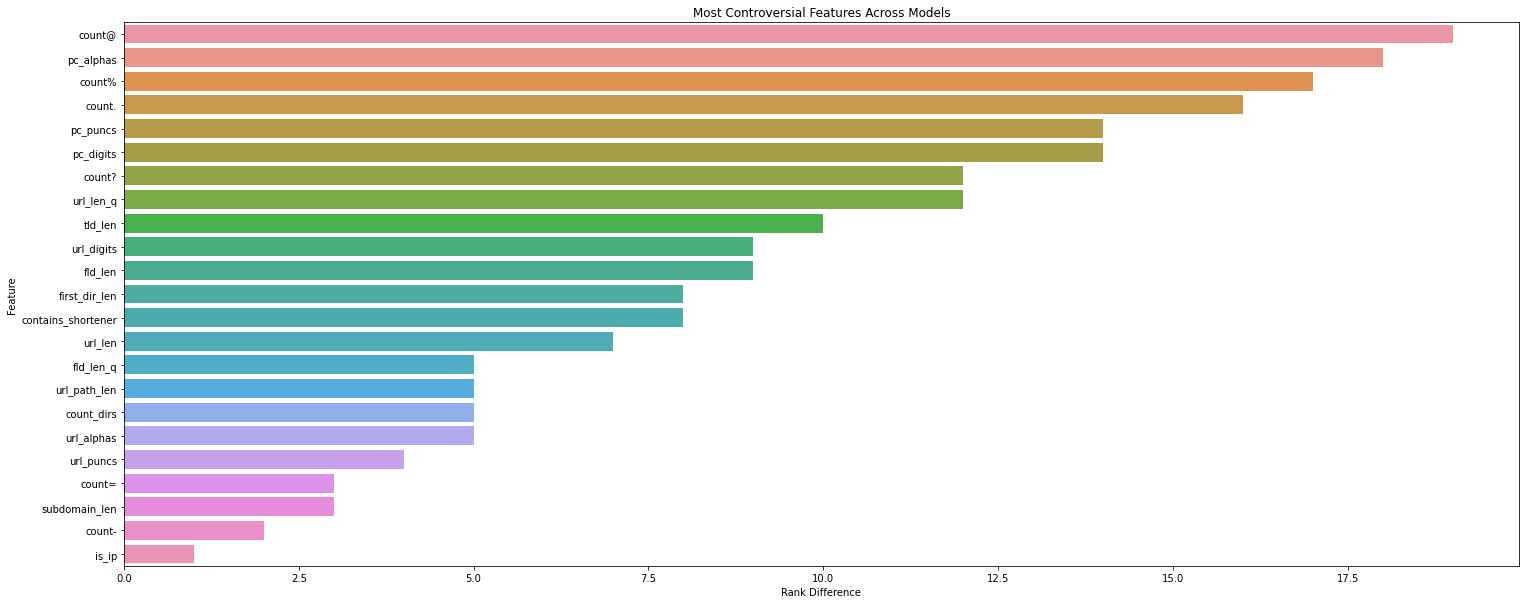

In [ ]:
feature_importances = feature_importances.sort_values(by='rank_diff', ascending=False)
fig, axes = plt.subplots(1, figsize=(25, 10))
sns.barplot(data=feature_importances, x="rank_diff", y='features')
axes.set_title('Most Controversial Features Across Models')
axes.set_xlabel('Rank Difference')
axes.set_ylabel('Feature')